# Basic ML concepts via Linear Regression

The goal of regression is to define a model that explains one measurement using another (or multiple) measurement(s). For example we expect that on average the weight of people depends on their height. The simplest assumption is that a this relationship can be described by a straight line that *goes through our data*, which is called linear regression. 

Given a feature or measurement $x$ and another measurement $y$ we want to find the parameters of a line such that $y = f(x) = a \cdot x+b$. The goal of regression is to find optimal values for $a$ and $b$ so that we can predict the value for $y$. Usually we call these parameters **weights** and use the $w$ abbreviation so that $y = w_0 + w_1 \cdot x$.

Let's look at two variables from the wine dataset:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

sns.set_theme(style='white', palette='deep')

# Make plots somewhat interactive - requires ipympl to be installed
%matplotlib widget

In [ ]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [ ]:
wine.head(5)

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x='density', y='fixed acidity', ax=ax)
plt.show()

We see that there is a correlation between `density` and `fixed acidity`. We can try to find that actual relation and first assume that: `fixed acidity` = $w_0$ + $w_1 \cdot$ `density`. What we need to do is to find the optimal values for $w_0$ and $w_1$. This is the simplest linear "combination" that we can do: a fixed value, the bias $w_0$ and a parameter that multiplies the value of one feature.

Let's plot the result for some random choice of parameters e.g. $w_0=-90, w_1=100$:

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x='density', y='fixed acidity', ax=ax);
plt.plot(wine['density'], -90 + 100 * wine['density'], 'r');

## Estimating the error

We see that we are quite far away from the best solution. But how do we even define what the best solution is? We can do that by estimating the error that our model makes on average. Imagine that we measure the distance from each data point to the red line. The higher the distance, the higher the error. These distances are usually called *residuals*. In the end, we want a red line, that minimizes this error on average. Of course we will not be able to get our error down to zero, but we want to get as close as possible to it.

How can we calculate the residuals? Well we just need to subtract the predicted values from the actual values:

In [ ]:
actual_values = wine['fixed acidity']
predicted_values = -90 + 100 * wine['density']
distance_to_model = actual_values - predicted_values

The `distance_to_model` array corresponds to the red dotted distances in the plot below:

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x="density", y="fixed acidity")
plt.plot(wine["density"], predicted_values, "r")
plt.vlines(
    wine["density"], wine["fixed acidity"], predicted_values, "crimson", linestyle="dotted", alpha=0.2
);

Let's plot these distances/errors as a scatterplot to understand them better:

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=wine['density'],  y=distance_to_model, marker='x', color='red', ax=ax)
ax.set_ylabel('distance');

We see that we get some negative values on the left when the model predicts higher values than expected and positive when the model is lower than expected on the right. Let's just try to find a slightly better model:

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x='density', y='fixed acidity');
plt.plot(wine['density'], -589 + 600 * wine['density'], 'r');

In [ ]:
distance_to_model = wine['fixed acidity'] - (-589 + 600 * wine['density'])

fig, ax = plt.subplots()
ax = sns.scatterplot(x=wine['density'],  y=distance_to_model, marker='x', color='red', ax=ax)
ax.set_ylabel('distance');

This looks better, but we still need a better way of *quantifying* the quality of the model. We cannot just look at such error plots by eye. Of course, we can sum up all the individual residuals:

In [ ]:
total_error = np.sum(distance_to_model)
total_error

Does this make sense? Let's look at a histogram of our distance values:

In [ ]:
fig, ax = plt.subplots()
sns.histplot(distance_to_model).set(xlabel="Error");

If we just take the three largest bins, we should already have a total error of about -1000, so the error seems largely underestimated. The problem is that we are interested in the absolute distances of the model predictions to the actual values. We don't really care if they are larger or smaller. When we just sum up the distance, the negative and positive errors cancel each other out, leading to an underestimation. 

In the worst case, our model predicts values that are too high for half of the samples and values that are too low for the other half. In tbhis case, the error might appear to be close to zero. What we need is an estimation of the absolute error. We could take the absolute value $abs(x)$, but generally what is done is to just take the square of the errors. Now a distance of -3 or +3 always has an error of 9 as $3^2 = -3^2$. Additionally, this *punishes* larger errors much more than smaller errors.

Let's compute the sum of the squared distances:

In [ ]:
square_error = np.sum(distance_to_model**2)
square_error

## Finding the best solution

In most cases, we will find the best values for the parameters $w_0$ and $w_1$ through an iterative process: we start from a random point and then try to minimize the error of our model. In a simple case like ours, we could just make a grid of possible values for $w_0$ and $w_1$ and check which are the best. Below you can see how this is done. The code might be quite complicated at first to understand, so here is an explanation of what it does:

1. Create ranges for the different $w_0$ and $w_1$ that we want to test
2. Create a meshgrid from the two ranges. A meshgrid is a way to generate coordinate grids from two 1D arrays, producing 2D arrays that represent all combinations of those values. It’s commonly used to evaluate functions over a grid without using nested loops (vectorization).
3. Compute the predicted `fixed acidity` value for all of the $w_0$ and $w_1$ combinations in the grid.
4. Calculate the errors for each classifier (each combination of $w_0$ and $w_1$).
5. Find the indices in the grid (corresponding to a specifc pair of $w_1$ and $w_2$ parameter values) that produced the smallest error.
6. Plot the errors error surface using a heatmap.


In [ ]:
# 1. Specify the different ranges that we want to explore
w0_range = np.arange(-1000, 0, 5)
w1_range = np.arange(0, 1000, 5)

# 2. Create a grid of values for the parameters
grid_0, grid_1 = np.meshgrid(w0_range, w1_range)

# 3. Predict the fixed acidity values for each combination of parameters (w0, w1)
grid_mult = grid_0[:,:,np.newaxis] + grid_1[:,:,np.newaxis] * wine['density'].values

# 4. Compute the squared error for each combination of parameters
grid_mult = (grid_mult - wine['fixed acidity'].values)**2
total_error = np.sum(grid_mult, axis=2)

# 5. Find the minimal error
min_loc = np.unravel_index(np.argmin(total_error), total_error.shape)

# 6. Plot the error surface
fig, ax = plt.subplots()
im = ax.imshow(total_error, extent=[w0_range[0],w0_range[-1],w1_range[-1],w1_range[0]],cmap=cm.coolwarm)
ax.plot([grid_0[min_loc[0],min_loc[1]]], [grid_1[min_loc[0],min_loc[1]]], 'y*', markersize=10)

ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
fig.colorbar(im, ax=ax);

In this plot we see the error of the model (how well it goes through the points) for each pair of values $w_0$, $w_1$. Dark blue represents a better model while red represents models that perform worse. The yellow star indicates the best possible solution with values:

In [ ]:
w0 = grid_0[min_loc[0],min_loc[1]]
w0

In [ ]:
w1 = grid_1[min_loc[0],min_loc[1]]
w1

We can now use this values in our equation $y=w_0 + w_1*x$:

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x='density', y='fixed acidity');

densities = np.arange(wine.density.min(), wine.density.max(), 0.001)
plt.plot(densities, w0 + densities * w1, 'r');

Usually we cannot directly compute the optimal value (yellow star location) because it would take way too much time to compute the error for all combinations of parameters. In that case we would start from a random point and search for the solution in an *iterative* way. We can represent the error plot in 3D to understand better. Let's assume we start from the location of the green dot:

In [ ]:
fig = plt.figure(figsize=(5,5))

X = grid_0.copy()
Y = grid_1.copy()
Z = total_error.copy()

ax = fig.add_subplot(1, 1, 1, projection='3d',computed_zorder=False)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)#, vmax=5)

# Add green dot and yellow star to indicate start and goal
ax.scatter([grid_0[180, 150]],[grid_1[180, 150]], [total_error[180, 150]], c='green', marker='o', s=50)
ax.scatter([grid_0[min_loc[0],min_loc[1]]],[grid_1[min_loc[0],min_loc[1]]], [total_error[min_loc[0],min_loc[1]]], c='yellow', marker="*", s=50)

ax.set_xlabel('$w_1$', fontdict={'fontsize':20})
ax.set_ylabel('$w_0$', fontdict={'fontsize':20});

We can now imagine taking many small steps downhill. Eventually, we would reach the bottom of the blue valley, where the yellow star is, which would correspond to the best value. This approach is very common in ML and is called gradient descent, gradient being a synonym for slope. The idea of the algorithm is to follow the steepest slope to find the minimal error!

## Finding the best solution with scikit-learn

In reality, we don't have to perform all these steps ourselves, we can use algorithm that have been implemented and optimized in libraries like scikit-learn. The simplest such algorithm is just called ```LinearRegression``` and is available in the submodule ```linear_model``` (technically, ```LinearRegression``` doesn't use gradient descent but ```LinearRegressionSGD``` does):

In [ ]:
from sklearn import linear_model

A large part of the algorithms implemented in scikit-learn in a similar way:

1. Create arrays containing the independent ($X$) and dependent ($y$) variables
2. Instantiate a chosen model, e.g. `LinearRegression` with some optional parameters specific to the method
3. "Train" or "fit" the model, i.e. find the optimal parameters for your dataset
4. Use the trained model for predictions

In our current example, the independent variable is just the ```density``` column:

In [ ]:
X = wine[['density']].values
X.shape

Note that we pass a **list** of columns even though we have a single column. If we do not do this, then the returned $X$ has a single dimension but sklearn expects in general 2D objects (tables/matrices). The reason behind this is that you would usually use multiple features for $X$, in which case you would actually select multiple columns from your DataFrame.

The variable that we want to precit can be a single vector, therefore we can just set:

In [ ]:
y = wine['fixed acidity'].values

Now we instantiate our model:

In [ ]:
model = linear_model.LinearRegression()

Finally, we call the ```fit``` method using our *training data* $X$ and $y$:

In [ ]:
res = model.fit(X=X, y=y)

The ```res``` object contains all the information about our fit. In particular it contains the values of the parameters in ```coef_```, which corresponds to $w_1$ in our case:

In [ ]:
res.coef_

To get the first term $w_0$ we need to look up the  intercept, which can be accessed as follows:

In [ ]:
res.intercept_

Now that we have model we can make a **prediction**, i.e. guess the value of $y$ (here fixed acidity) given a specific value x (here density). Let's try that for $x=0.996$:

In [ ]:
model.predict([[0.996]])

Note that here again, to do this prediction we use a list of lists ```[[0.996]]``` even for a single number. We trained with a 2D object, so we predict with a 2D object as well. Of course, we can do a prediction for an entire series of numbers:

In [ ]:
X_pred = np.arange(0.99, 1.004, 0.001)
X_pred = X_pred[:, np.newaxis]
X_pred.shape

Note that here we use ```np.newaxis``` to transform again our 1D list genereated by ```np.arange``` into 2D data:

In [ ]:
y_pred = model.predict(X_pred)

Naturally, we can plot again the result:

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x='density', y='fixed acidity');
plt.plot(X_pred, y_pred, 'r');

We see that the values that we get are close to our approximation above. It we were using a finer grid for our approximation we would end up with the same values.

## Measuring quality with scikit-learn

Above, we have always manually computed an error e.g. as the sum or mean of squared distances between points and their predictions:

In [ ]:
y_train = model.predict(X)

np.mean((y_train -y)**2)

Instead of doing this manually with the risk of making a mistake, we can also use function from scikit-learn. Those functions compute so-called metrics, such as the mean squared error and are located in the ```metrics``` submodule of scikit-learn. We will see such metrics in other contexts, especially classification, and they always require the true and predicted data:

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_train, y)

## Exercise

1. Import the co2 dataset called `co2_countries` from the dataset directory. This dataset contains information C02 emissions between 1990-2022 of Germany and France

2. With seaborn make a scatter plot of ```co2_per_capita``` vs ```Year```. Color data by country.

3. Using scikit learn's ```LinearRegression``` fit a model to the relation between ```co2_per_capita``` and ```Year``` for Germany and France **separately**.

4. Plot the scatterplot and the fitted linear models on top of it.

5. Which country can be better described by this linear model? Compute the mean square error of the two models.

6. What is the emission per capita predicted for France in 2030?

## Solution

In [73]:
df = pd.read_csv("../../datasets/co2_countries.csv")
df.head()

,Country,co2_per_capita,Year
0,France,8.740552,1990
1,France,8.903264,1991
2,France,9.600755,1992
3,France,8.842668,1993
4,France,8.603079,1994


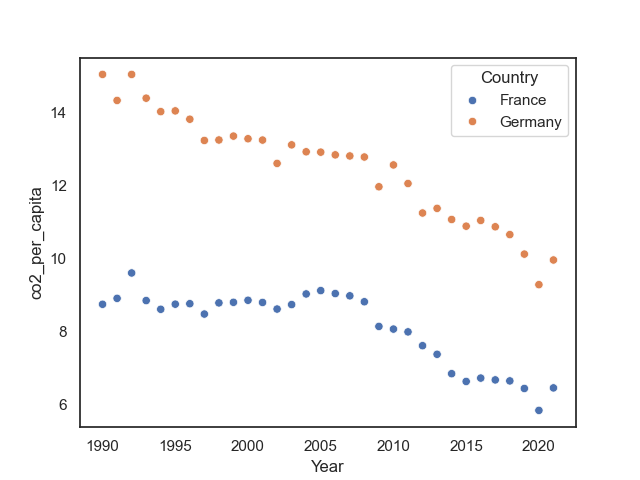

In [74]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="Year", y="co2_per_capita", hue="Country", ax=ax);

In [75]:
df_germany = df[df["Country"] == "Germany"]
df_france = df[df["Country"] == "France"]

model_germany = linear_model.LinearRegression()
model_germany.fit(X=df_germany[["Year"]].values, y=df_germany["co2_per_capita"].values)

model_france = linear_model.LinearRegression()
model_france.fit(X=df_france[["Year"]].values, y=df_france["co2_per_capita"].values)

LinearRegression()

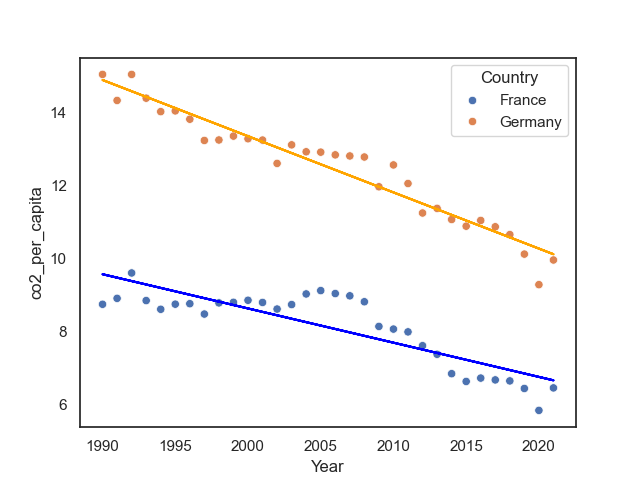

In [76]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="Year", y="co2_per_capita", hue="Country", ax=ax)


ax.plot(df["Year"], model_germany.predict(df[["Year"]].values), 'orange')
ax.plot(df["Year"], model_france.predict(df[["Year"]].values), 'blue');

We can see that the orange curve (i.e. the regression for Germany) leads to smaller errors, especially around the year 2005. Let's confirm this by computing the errors:

In [77]:
from sklearn.metrics import mean_squared_error

error_germany = mean_squared_error(df_germany["co2_per_capita"], model_germany.predict(df_germany[["Year"]].values))
error_france = mean_squared_error(df_france["co2_per_capita"], model_france.predict(df_france[["Year"]].values))

print(f"Error for Germany: {error_germany}")
print(f"Error for France: {error_france}")

Error for Germany: 0.1345878859185955
Error for France: 0.2839799055278137


We can also visualize the residuals directly on the scatter plot:

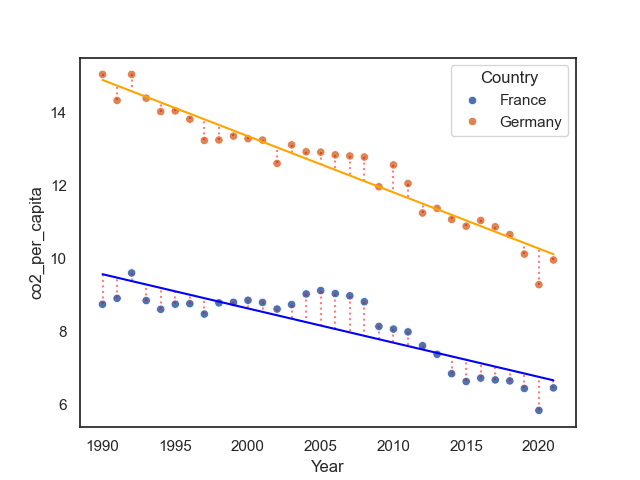

In [78]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="Year", y="co2_per_capita", hue="Country", ax=ax)

pred_germany = model_germany.predict(df_germany[["Year"]].values)
pred_france = model_france.predict(df_france[["Year"]].values)

# Plot residuals
ax.vlines(
    df_germany["Year"],
    df_germany["co2_per_capita"],
    pred_germany,
    color="red",
    linestyle="dotted",
    alpha=0.5,
)
ax.vlines(
    df_france["Year"],
    df_france["co2_per_capita"],
    pred_france,
    color="red",
    linestyle="dotted",
    alpha=0.5,
)

ax.plot(df_germany["Year"], pred_germany, "orange")
ax.plot(df_france["Year"], pred_france, "blue");

In [79]:
prediction = model_france.predict([[2030]])

print(f"Predicted emission per capita for France in 2030: {prediction[0]:.2f}")

Predicted emission per capita for France in 2030: 5.81
